In [1]:
# Load various imports 
import pandas as pd
import os
import librosa
import glob
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

import pickle
from tqdm import tqdm

from keras.layers import Permute
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.recurrent import GRU, LSTM
from tensorflow.keras.utils import Sequence
from librosa import display



from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, CuDNNLSTM, BatchNormalization
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Reshape, TimeDistributed
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from keras.models import load_model
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
import datetime

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

from scipy import stats, signal
import acoustics
from acoustics.signal import bandpass
from acoustics.bands import (_check_band_type, octave_low, octave_high, third_low, third_high)

import matplotlib.pyplot as plt

%matplotlib inline

#from keras.callbacks import TensorBoard
from time import time

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


def t60_impulse(raw_signal,fs, bands, rt='t30'):  # pylint: disable=too-many-locals
    """
    Reverberation time from a WAV impulse response.
    :param file_name: name of the WAV file containing the impulse response.
    :param bands: Octave or third bands as NumPy array.
    :param rt: Reverberation time estimator. It accepts `'t30'`, `'t20'`, `'t10'` and `'edt'`.
    :returns: Reverberation time :math:`T_{60}`
    """
    #fs, raw_signal = wavfile.read(file_name)
    band_type = _check_band_type(bands)

    if band_type == 'octave':
        low = octave_low(bands[0], bands[-1])
        high = octave_high(bands[0], bands[-1])
    elif band_type == 'third':
        low = third_low(bands[0], bands[-1])
        high = third_high(bands[0], bands[-1])

    rt = rt.lower()
    if rt == 't30':
        init = -5.0
        end = -35.0
        factor = 2.0
    elif rt == 't20':
        init = -5.0
        end = -25.0
        factor = 3.0
    elif rt == 't10':
        init = -5.0
        end = -15.0
        factor = 6.0
    elif rt == 'edt':
        init = 0.0
        end = -10.0
        factor = 6.0

    t60 = np.zeros(bands.size)

    for band in range(bands.size):
        # Filtering signal
        filtered_signal = bandpass(raw_signal, low[band], high[band], fs, order=8)
        abs_signal = np.abs(filtered_signal) / np.max(np.abs(filtered_signal))

        # Schroeder integration
        sch = np.cumsum(abs_signal[::-1]**2)[::-1]
        sch_db = 10.0 * np.log10(sch / np.max(sch))

        # Linear regression
        sch_init = sch_db[np.abs(sch_db - init).argmin()]
        sch_end = sch_db[np.abs(sch_db - end).argmin()]
        init_sample = np.where(sch_db == sch_init)[0][0]
        end_sample = np.where(sch_db == sch_end)[0][0]
        x = np.arange(init_sample, end_sample + 1) / fs
        y = sch_db[init_sample:end_sample + 1]
        slope, intercept = stats.linregress(x, y)[0:2]

        # Reverberation time (T30, T20, T10 or EDT)
        db_regress_init = (init - intercept) / slope
        db_regress_end = (end - intercept) / slope
        t60[band] = factor * (db_regress_end - db_regress_init)
    return t60



#------------------------------------------------------------------------------------------




/home/pcallens/miniconda3/envs/kerasenv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/pcallens/miniconda3/envs/kerasenv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
/home/pcallens/miniconda3/envs/kerasenv/lib/python3.7/site-packages/matplotlib/mpl-data/styleli

In [2]:
def pre_process(music_folder, rev_music_folder, output_folder,
            window_size, mfcc_bands,n_channels,
            mfcc_degree, y_params):

    #Create output folders
    try:
        os.mkdir(output_folder)
    except:
        print("Output folder already exist")
    try:
        os.mkdir(output_folder + "X")
    except:
        print("X folder already exist")
    
    for music_file in tqdm(glob.glob(music_folder + '*.wav')):
        
        #Load music:
        try: 
            music, m_sr = librosa.load(music_file, res_type='kaiser_fast')
        except Exception as e:
            print("Error encountered while parsing music file: ", music_file)
            return None 
        
        music_mfcc = librosa.feature.mfcc(y=music, sr=m_sr, n_mfcc= mfcc_bands,hop_length=512, n_fft=1024)
        music_mfcc = librosa.util.fix_length(music_mfcc, window_size, axis=1, mode='wrap') #Reshape to windom size
        music_mfcc = librosa.util.normalize(music_mfcc, axis=1)
    
        for room_folder in glob.glob(rev_music_folder + '/*'):
            #Create output room folder
            output_room_folder = output_folder + "X/" + os.path.split(room_folder)[1]
            try:
                os.mkdir(output_room_folder)
            except:
                pass
            for rev_music_file in glob.glob(room_folder + '/*'):
                # /!\ The track name has to be exactly included in the recorded track name
                #print(f'musicfile : {os.path.basename(music_file)}')
                #print(f'revmusicfile : {os.path.basename(rev_music_file)}')
                if os.path.splitext(os.path.basename(music_file))[0] in os.path.basename(rev_music_file):
                    #Load reverberant music:
                    try: 
                        rev_music, rev_m_sr = librosa.load(rev_music_file, res_type='kaiser_fast')
                    except Exception as e:
                        print("Error encountered while parsing reverberant music file: ", rev_music_file)
                        return None 
                    
                    rev_music_mfcc = librosa.feature.mfcc(y=rev_music, sr=rev_m_sr, n_mfcc= mfcc_bands,hop_length=512, n_fft=1024)
                    rev_music_mfcc = librosa.util.fix_length(rev_music_mfcc, window_size, axis=1, mode='wrap') #Reshape to windom size
                    rev_music_mfcc = librosa.util.normalize(rev_music_mfcc, axis=1)
                    
                    if n_channels == 1 :
                        X = rev_music_mfcc
                    else :
                        X = np.dstack((music_mfcc, rev_music_mfcc))
                    #print(f'saved {os.path.split(os.path.splitext(rev_music_file)[0])[1] + ".pkl"}')
         
                    with open(output_room_folder + '/' + os.path.split(os.path.splitext(rev_music_file)[0])[1] + ".pkl", "wb") as f:
                        pickle.dump(X, f)
                        f.close()

In [3]:

# Parameters
params = {'window_size': 645,
          'mfcc_bands': 40,
          'mfcc_degree': 2,
          'y_params': 't60',
          'n_channels': 2}


# Data
data_folder = "Datasets/Logi_measures/"

music_folder = data_folder + "Music/"
rir_folder = data_folder + "RIR/"
rev_music_folder = data_folder + "Reverberant_music/"

output_folder = data_folder + "Preprocessed/"



In [4]:
pre_process(music_folder, rev_music_folder, output_folder,**params)

  0%|          | 0/20 [00:00<?, ?it/s]

Output folder already exist
X folder already exist


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


In [5]:
#Listening tool
#ipd.Audio(np.array(music_rev_same),rate=22050)

#visualize tool
#

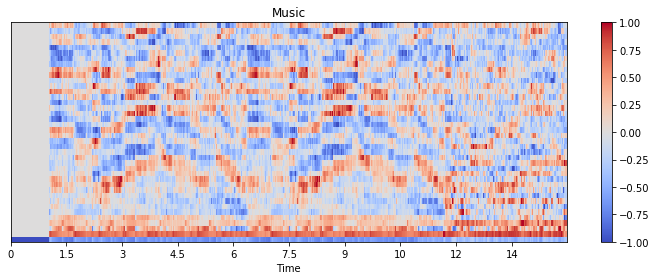

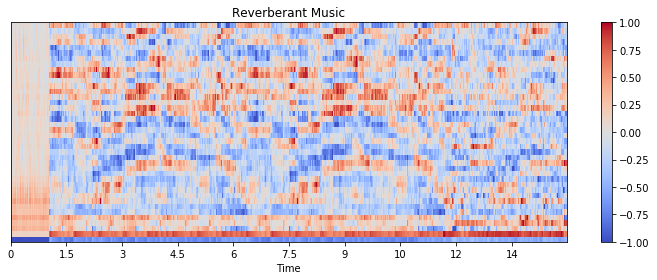

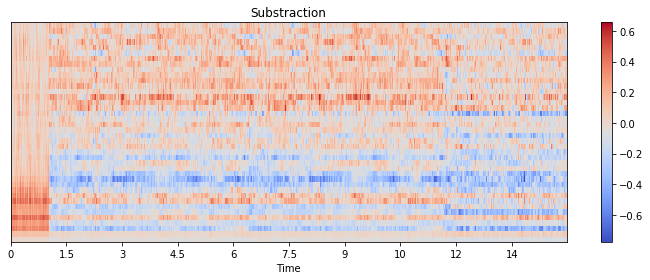

In [4]:
with open("Datasets/Logi_measures/Preprocessed/X/LivingRoom/Track1_LivingRoom.pkl",'rb') as f:
    test = pickle.load(f)

plt.figure(figsize=(10, 4))
librosa.display.specshow(test[:,:,0], x_axis='time')
plt.colorbar()
plt.title('Music')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(test[:,:,1], x_axis='time')
plt.colorbar()
plt.title('Reverberant Music')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(test[:,:,1] - test[:,:,0], x_axis='time')
plt.colorbar()
plt.title('Substraction')
plt.tight_layout()
plt.show()

# TESTS

In [5]:
def feature_normalize(dataset):
    return (dataset - np.mean(dataset, axis=0)) / np.abs(dataset).max(axis=0)

In [6]:
with open("last-t60/X/2.pkl",'rb') as f:
    test2 = pickle.load(f)
f.close()

In [7]:
test2.shape

(40, 645, 2)

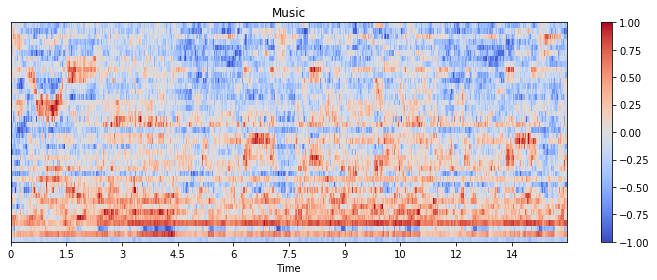

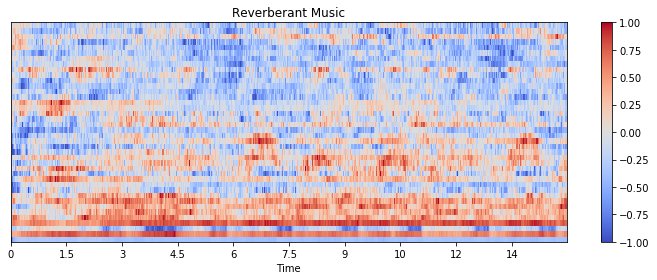

ValueError: operands could not be broadcast together with shapes (40,645) (1,40,2) 

<Figure size 720x288 with 0 Axes>

In [27]:
plt.figure(figsize=(10, 4))
librosa.display.specshow((test2[:,:,0]), x_axis='time')
plt.colorbar()
plt.title('Music')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(test2[:,:,1], x_axis='time')
plt.colorbar()
plt.title('Reverberant Music')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(test2[:,:,1] - test[:,:,0], x_axis='time')
plt.colorbar()
plt.title('Substraction')
plt.tight_layout()
plt.show()

In [28]:
test2.shape

(40, 645, 2)

In [29]:
test = test2.reshape((1,params['mfcc_bands'], params['window_size'],params['n_channels']))
test.shape

(1, 40, 645, 2)

In [30]:
preds = model.predict(test)

In [31]:
with open("Preprocessed_NoDelay_smaller2_440/y/2.pkl",'rb') as f:
    test3 = pickle.load(f)
f.close()

In [32]:
test3

array([2.32511916, 2.02050425, 1.86483142, 1.81557451, 1.86166703,
       1.99323328, 2.08869901, 2.02495038, 1.87196085, 1.7369366 ,
       1.57959595, 1.29144302, 1.07520682])

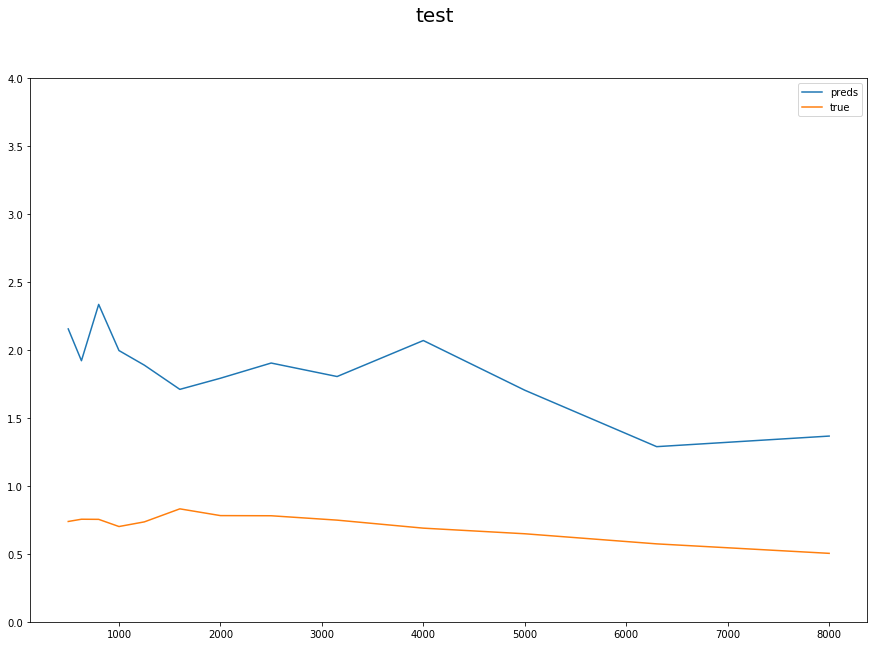

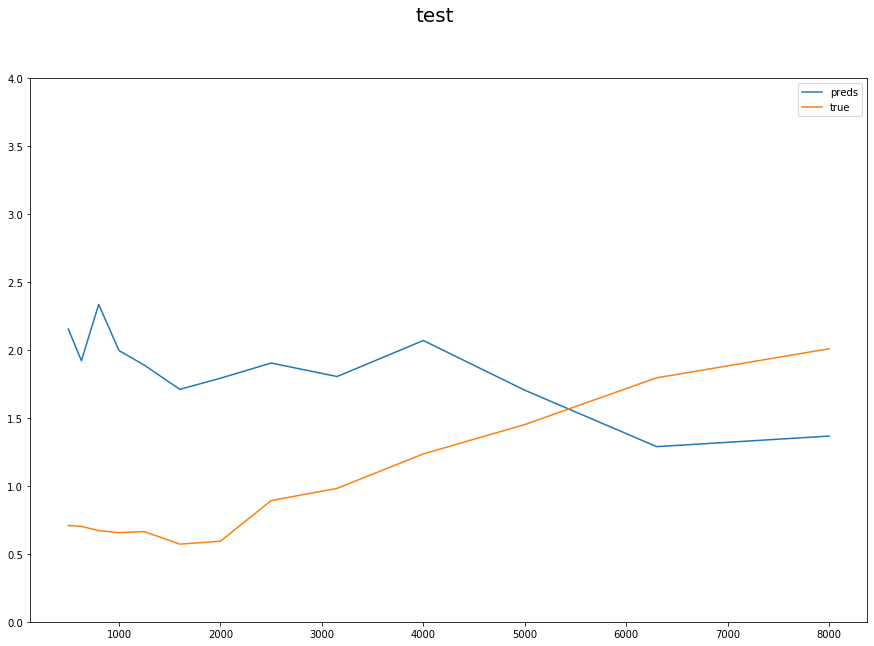

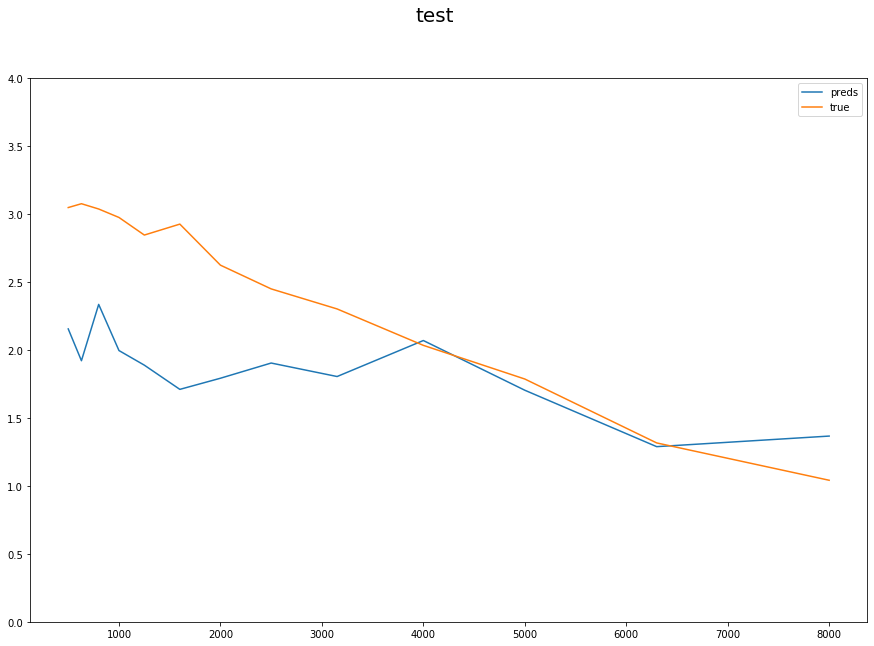

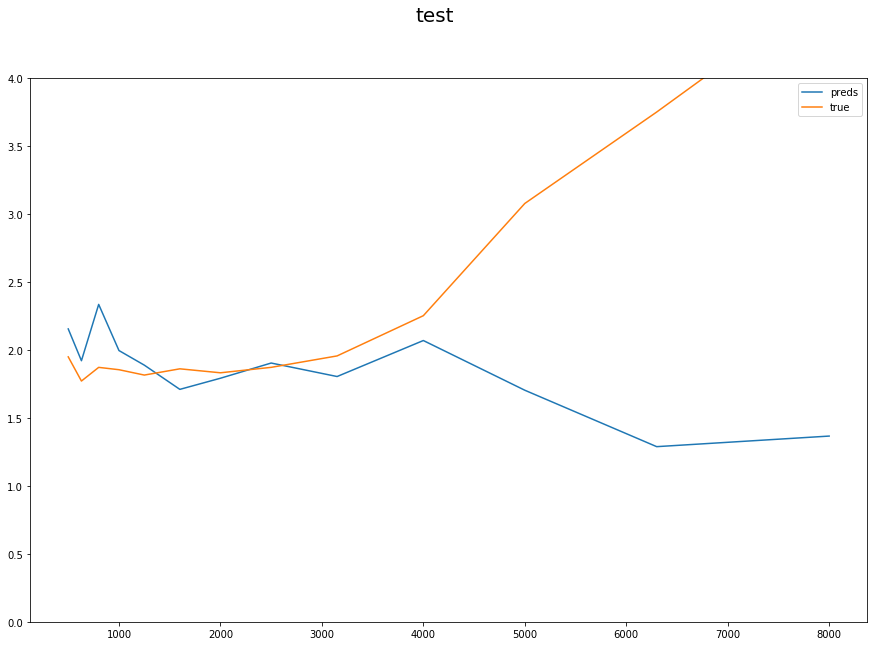

In [34]:
bands = acoustics.bands.third(500,8000)

for i in [9000,10000,2400,4300]:
    
    with open("last-t60/y/t60/"+str(i)+".pkl",'rb') as f:
        test3 = pickle.load(f)
    f.close()

    with open("last-t60/X/"+str(i)+".pkl",'rb') as f:
        test2 = pickle.load(f)
    f.close()
    
    preds = model.predict(test)
    
    fig = plt.figure(figsize=(15,10))
    #plt.xscale('log')
    plt.plot(bands, preds.flatten()) 
    plt.plot(bands, test3) 
    fig.suptitle('test', fontsize=20)

    plt.ylim(bottom=0,top=4)

    plt.legend(['preds','true'])
    plt.show()

# LOAD MODEL and predict

In [5]:
def CRNN2D(X_shape, nb_classes):
    '''
    Model used for evaluation in paper. Inspired by K. Choi model in:
    https://github.com/keunwoochoi/music-auto_tagging-keras/blob/master/music_tagger_crnn.py
    '''

    nb_layers = 4  # number of convolutional layers
    nb_filters = [64, 128, 128, 128]  # filter sizes
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'elu'  # activation function to use after each layer
    pool_size = [(2, 2), (4, 2), (4, 2), (4, 2),
                 (4, 2)]  # size of pooling area

    # shape of input data (frequency, time, channels)
    input_shape = (X_shape[1], X_shape[2], X_shape[3])
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model and normalize along frequency axis
    model = Sequential()
    
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))
   
    # First convolution layer specifies shape
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(MaxPooling2D(pool_size=pool_size[0], strides=pool_size[0],))
    model.add(Dropout(0.1))

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting
        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1],
                              data_format="channels_first"))  # Max pooling
        model.add(Dropout(0.1))

        # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(nb_classes))
    model.add(Activation("relu"))
    return model

In [6]:
output_size = 13
model = CRNN2D((None,params['mfcc_bands'], params['window_size'],params['n_channels']), output_size)

#load previous weights
model.load_weights("weights.best.t60_2s.hdf5")
#model.load_weights("weights-Copy1.best.RCNN_8000.hdf5")
#model.load_weights("weights.best.RCNN_8000-revonly.hdf5")
#model.load_weights("weights.best.RCNN_smaller2_440_2.hdf5")

model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
def plot_X_mfccs(X):
    plt.figure(figsize=(20, 6))
    librosa.display.specshow(X[:,:,0], x_axis='time')
    plt.colorbar()
    plt.title(' music')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 6))
    librosa.display.specshow(X[:,:,1], x_axis='time')
    plt.colorbar()
    plt.title('X rev music')
    plt.tight_layout()
    plt.show()

In [8]:
def room_prediction(room_folder,params,avg=False):
    y_pred = []
    
    for X_file in glob.glob(room_folder + '/*.pkl'):
        #print(X_file)
        with open(X_file,"rb") as f:
            X = pickle.load(f)
            #print(f'X_file = {X_file}')
            #plot_X_mfccs(X)
        #print(X.shape)
            y_pred.append(model.predict(X.reshape((1,params['mfcc_bands'], params['window_size'],params['n_channels']))))
            f.close()
        #if room_folder in 'Datasets/Matt_audio_files/Preprocessed_matt_dataset/X/Location1/Track1_Location1.pkl':
        #    print(np.squeeze(np.array(y_pred)).shape)
        #    print(y_pred)
    if avg:
        return np.mean((np.squeeze(np.array(y_pred),axis=1)))
    else :
        return(np.squeeze(np.array(y_pred),axis=1))

In [9]:

dataset_folder = output_folder

output_size = 13
bands = acoustics.bands.third(500,8000)
#room_folder = dataset_folder + 'X/'


In [10]:
def plot_room_prediction(room_preds,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    for track in room_preds:
        plt.plot(bands, track) 
    plt.legend((track_names))
    plt.show(fig)

In [11]:
def plot_mean_prediction_vs_true(room_preds,room_true,room_name):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    mean_preds = np.mean(room_preds,axis=0)
    
    plt.plot(bands, mean_preds) 
    #plt.legend((track_names))
    #plt.show(fig)
    
    #fig.suptitle(room_name, fontsize=20)
    #plt.xscale('log')
    #plt.ylim(bottom=0,top=1.5)
    for track in room_true:
        plt.plot(bands, track) 
    plt.legend((['True RT60','mean predicted RT60']))
    plt.show(fig)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
def boxplot_room_prediction(room_preds,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    
    plt.boxplot(room_preds[:,:],labels = bands)
    #for track in room_preds:
    #    plt.boxplot(bands,track[:,:]) 
    plt.legend((track_names))
    plt.show(fig)

In [14]:
def boxplot_room_prediction_test(room_preds,room_true,room_name,track_names):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    plt.xscale('log')
    plt.plot(bands, room_true) 
    fig.suptitle(room_name, fontsize=20)
    
    plt.ylim(bottom=0,top=1.5)
    locs, labels = plt.xticks()
    plt.boxplot(room_preds[:,:],positions = bands)
    plt.xticks(locs)
    #for track in room_preds:
    #    plt.boxplot(bands,track[:,:]) 
    plt.legend((track_names))
    plt.show(fig)

In [15]:
def plot_mean_prediction_vs_true_errbar(room_preds,room_true,room_name):
    bands = acoustics.bands.third(500,8000)
    #plt.title(name)
    fig = plt.figure(figsize=(15,10))
    
    fig.suptitle(room_name, fontsize=20)
    plt.xscale('log')
    plt.ylim(bottom=0,top=1.5)
    mean_preds = np.mean(room_preds,axis=0)
    
    print(len(room_preds[0]))
    
    error = []
    for i in range(len(room_preds[0])):
        #print(room_preds[i,:])
        quantiles = np.percentile(room_preds[i,:], [25,75])
        quantiles = [np.mean(room_preds[i]) - quantiles[0], quantiles[1] - np.mean(room_preds[i])]
        error.append(quantiles)
        
    error = np.array(error).T
    print(f'error ; {error} \n shape : {error.shape}')
    #print(len(error[1]))
    plt.errorbar(bands,  mean_preds,yerr=error,capsize=10) 
    #plt.legend((track_names))
    #plt.show(fig)
    
    #fig.suptitle(room_name, fontsize=20)
    #plt.xscale('log')
    #plt.ylim(bottom=0,top=1.5)
    for track in room_true:
        plt.plot(bands, track) 
    plt.legend((['True RT60','predicted RT60']))
    plt.show(fig)

13
error ; [[ 0.02327722  0.04150715  0.01672098  0.15804213  0.04495715  0.0193437
   0.01375124  0.00784421  0.01402053  0.44128975  0.03751868  0.03647304
   0.05302471]
 [ 0.02797598  0.04906842  0.02345875  0.16224694  0.04497208  0.02118751
   0.02523938  0.01331711  0.03355086 -0.44128975  0.04816198  0.03417701
   0.07251042]] 
 shape : (2, 13)


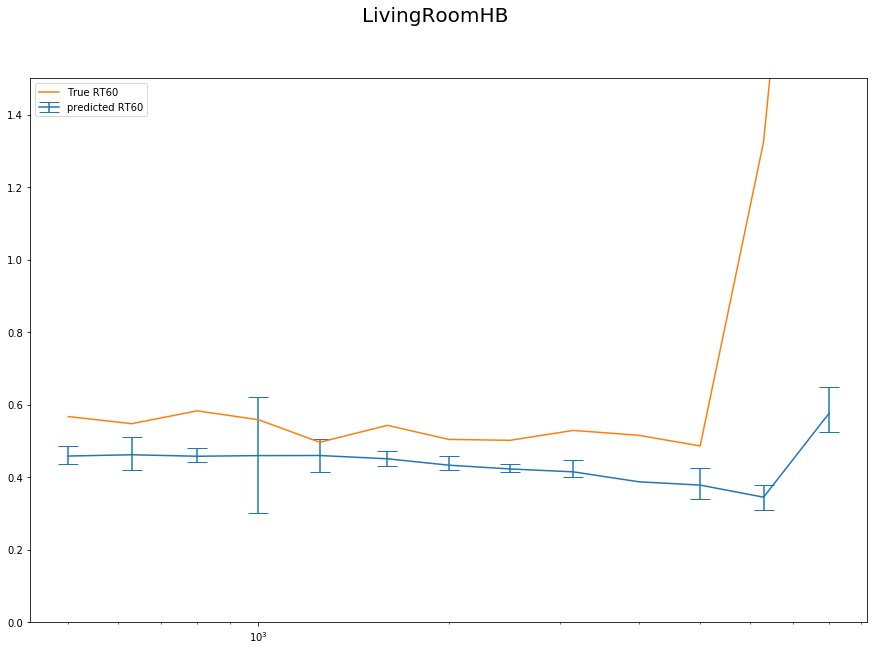

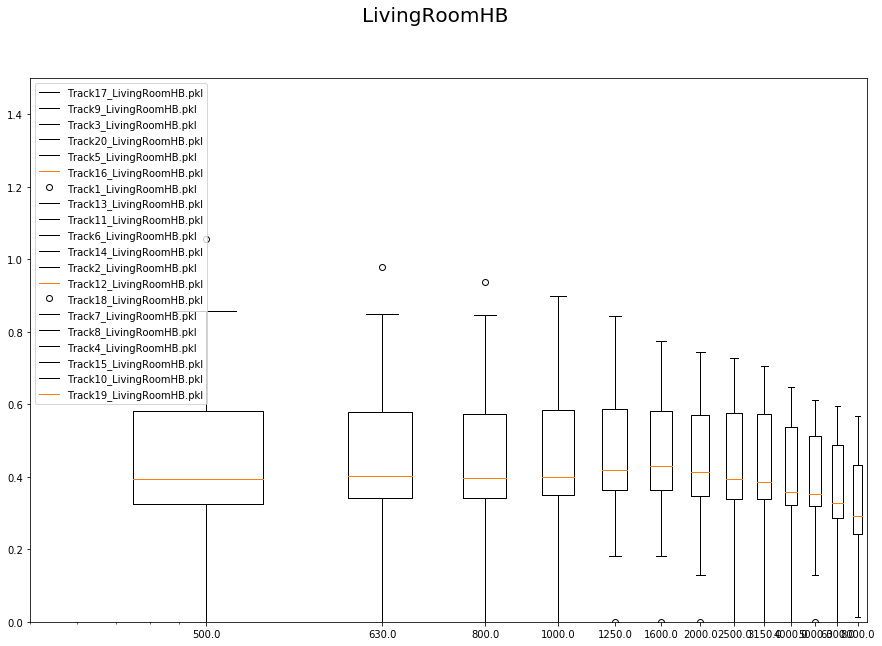

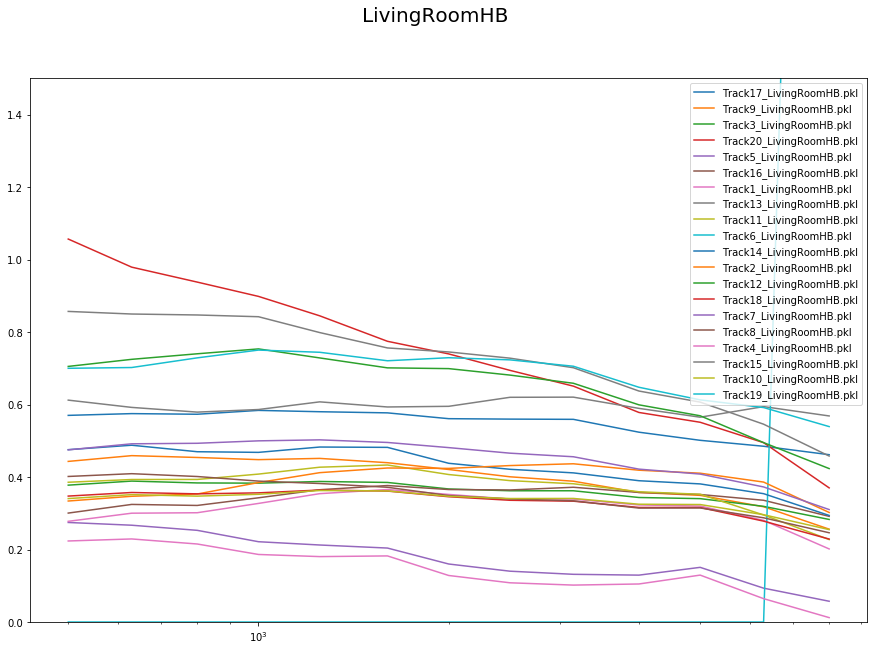

13
error ; [[0.00300893 0.08508986 0.00302713 0.05224127 0.00686124 0.01865017
  0.00909182 0.01038983 0.08694375 0.02584717 0.0228726  0.00472689
  0.13363498]
 [0.00858477 0.12390631 0.0119177  0.07021385 0.01916474 0.03558686
  0.01102564 0.01276657 0.12378937 0.04275194 0.03453326 0.02582344
  0.1499604 ]] 
 shape : (2, 13)


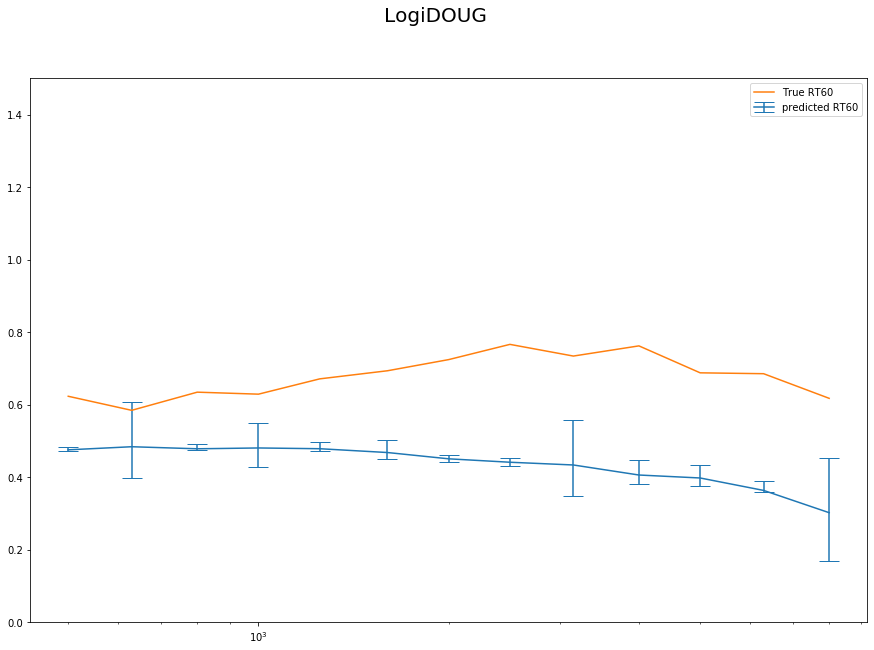

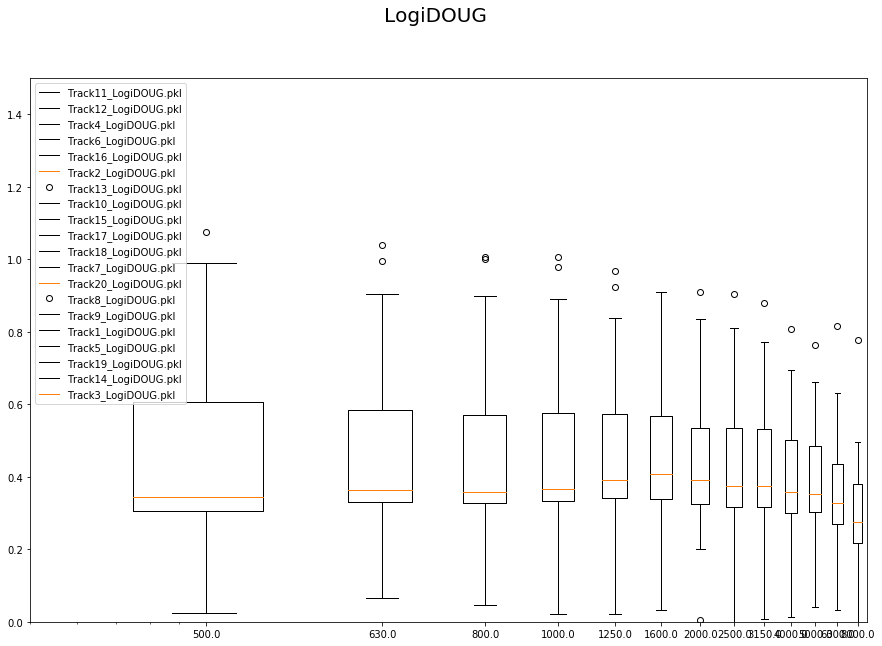

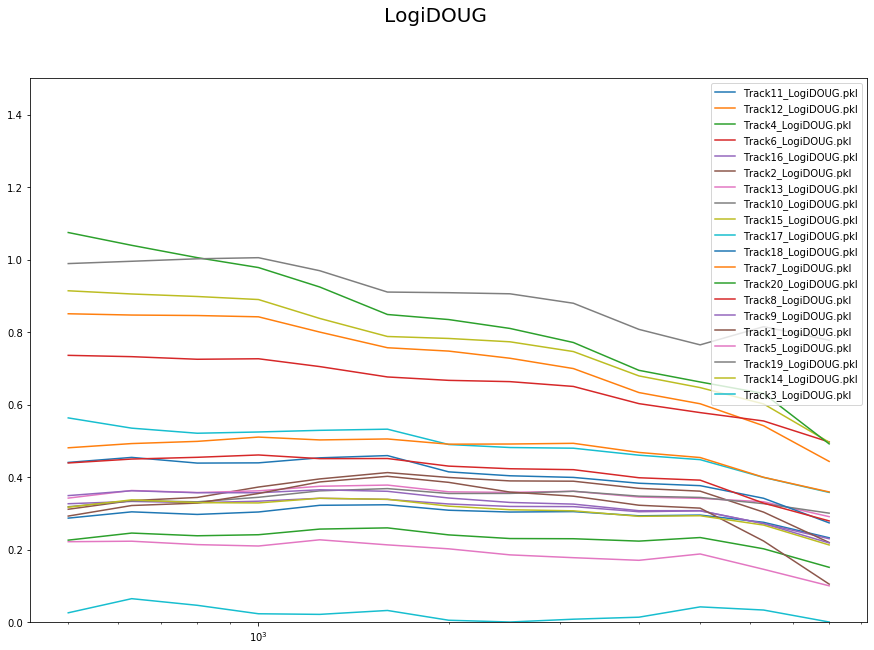

13
error ; [[ 0.01338238  0.1241495   0.02098723  0.00415313  0.01193738  0.01203427
   0.01181588 -0.00091927  0.00573266  0.01469849  0.05929226  0.02431893
   0.01078135]
 [ 0.02135092  0.14235604  0.0335858   0.02603626  0.02669567  0.01073068
   0.05235982  0.02458467  0.02684212  0.03255758  0.07523376  0.04091576
   0.02663529]] 
 shape : (2, 13)


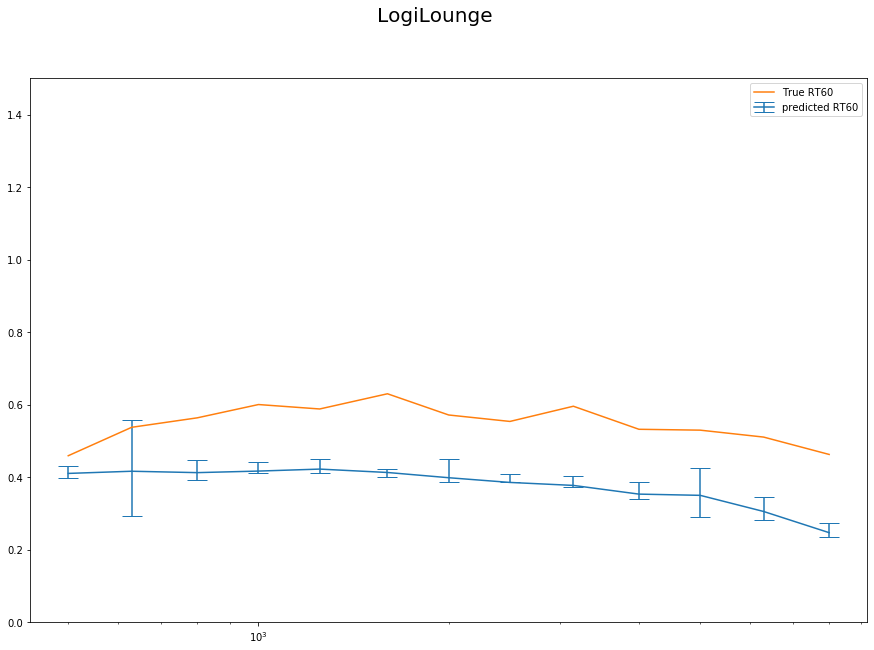

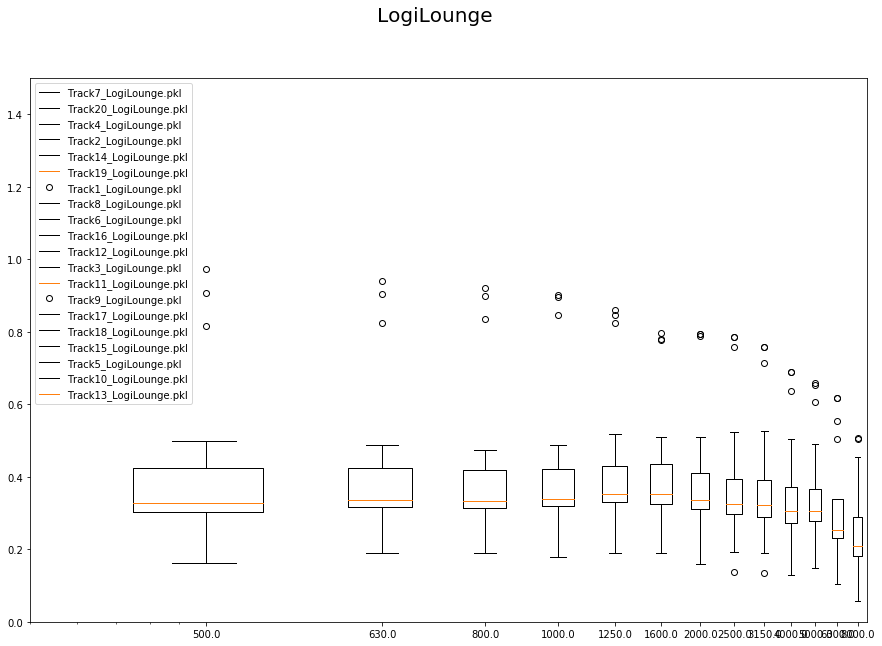

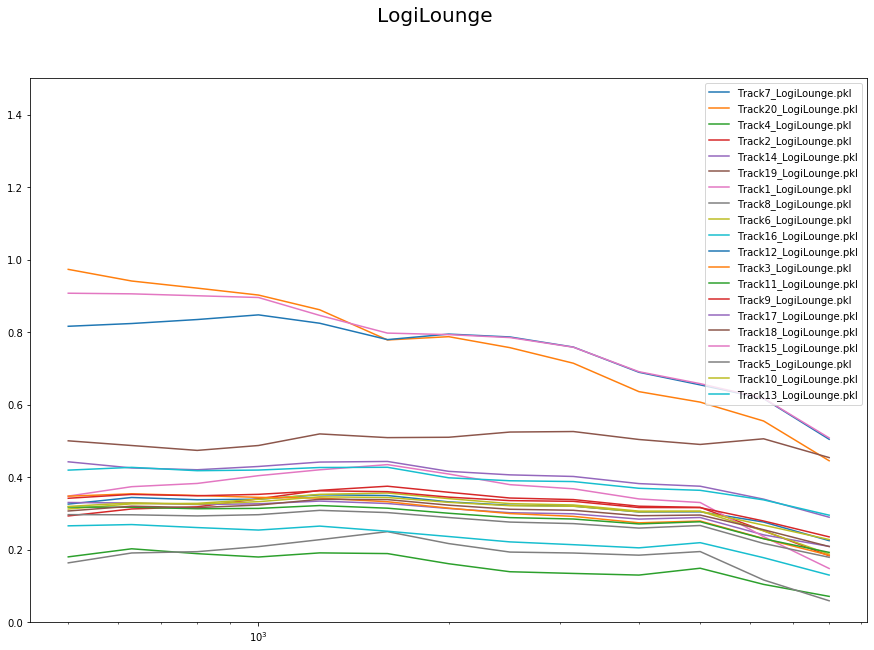

13
error ; [[0.00502723 0.10150987 0.02614969 0.00698537 0.03465208 0.11162573
  0.0877623  0.05020484 0.03250611 0.02773038 0.11648339 0.00712138
  0.0088498 ]
 [0.01598325 0.11031252 0.0384914  0.0272764  0.03799272 0.14019167
  0.12723386 0.04386644 0.0379647  0.04524502 0.14516574 0.03247321
  0.01689723]] 
 shape : (2, 13)


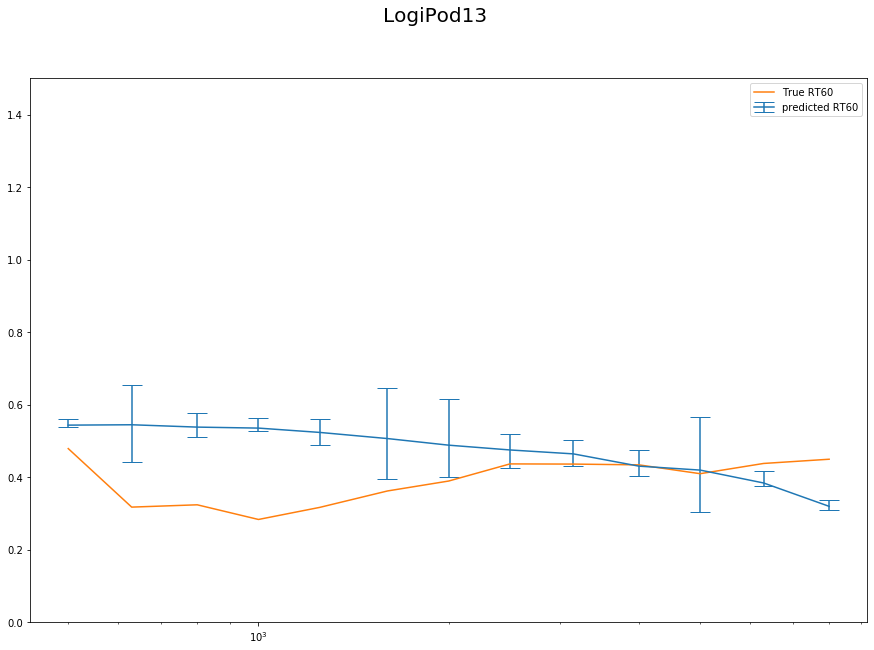

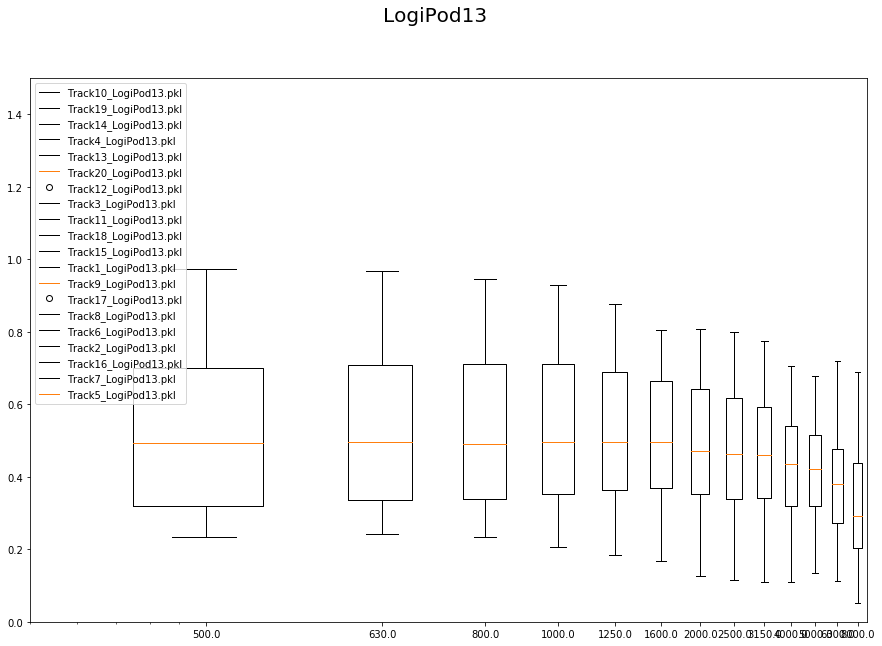

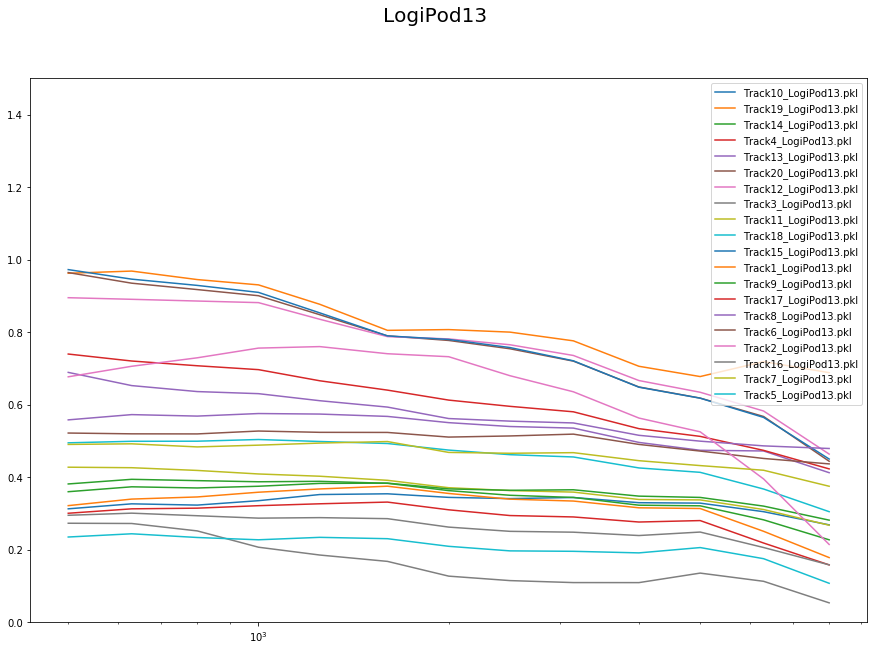

13
error ; [[ 0.00259033  0.00680828  0.00360863  0.01061359  0.00448189  0.01331612
   0.06012809  0.00315054  0.0170875   0.0330821   0.00368646  0.00696179
   0.00518566]
 [ 0.02205405  0.01401693 -0.00360863  0.02039757 -0.00448189  0.02170566
   0.08235288 -0.00315054  0.01852955  0.03796408  0.01347211  0.01492786
  -0.00518566]] 
 shape : (2, 13)


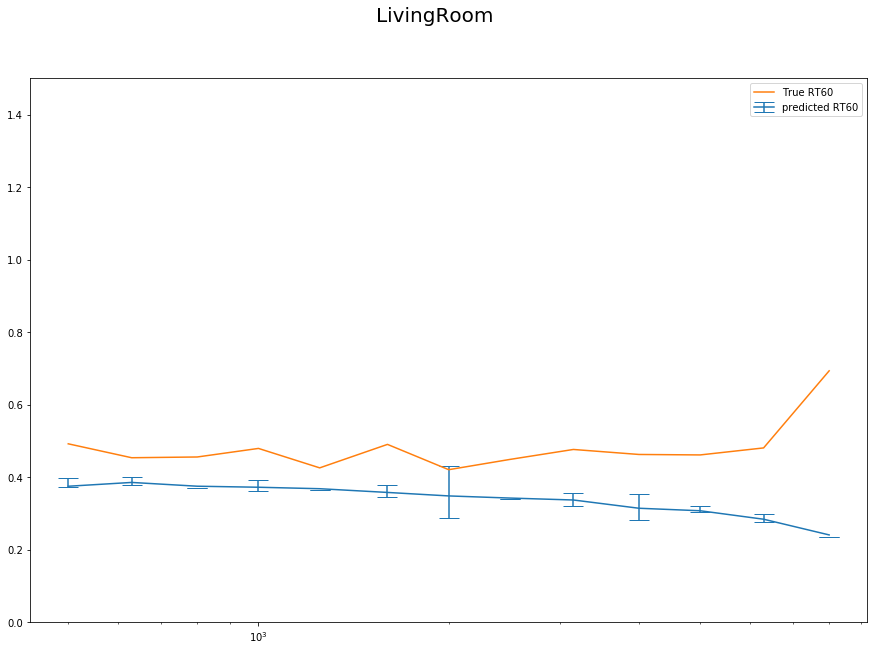

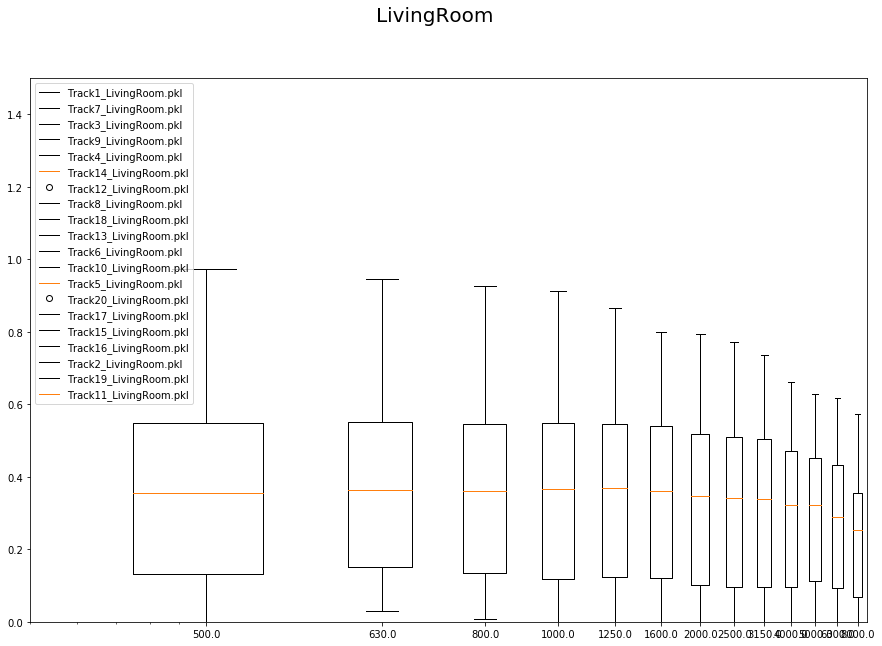

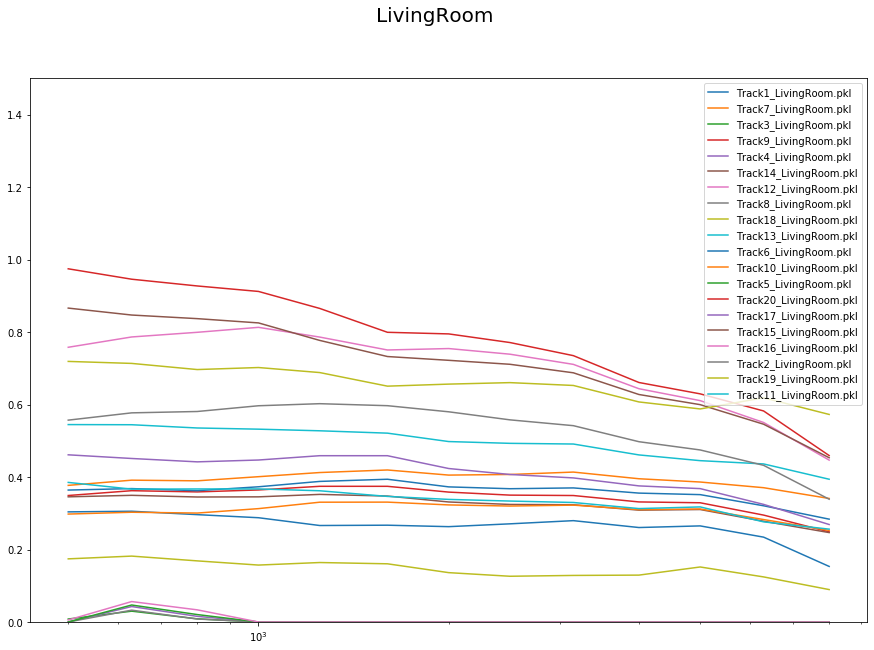

In [16]:
for room_folder_num in glob.glob(dataset_folder+'X/*'):
    room_name = os.path.split(room_folder_num)[1]
    track_names = [os.path.split(track)[1] for track in glob.glob(room_folder_num + '/*.pkl')]
    #print(f'roomfolder : {room_folder_num}')
    
    #print(rir_folder)
    rir,fs = librosa.load(rir_folder + room_name + '_RIR.wav')
    true_t60 = t60_impulse(rir,fs,bands)
    #print(f'{room_name} : {true_t60}')
    
    
    plot_mean_prediction_vs_true_errbar(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)


    #plot_room_prediction([true_t60], room_name=room_name, track_names = ['True RT60'],show=False)
    #print(np.mean(room_prediction(room_folder_num,params),axis=0).shape)
    #plot_room_prediction([np.mean(room_prediction(room_folder_num,params),axis=0)],room_name=room_name,track_names='Mean predicted RT60')
    #boxplot_room_prediction_test(room_prediction(room_folder_num,params),true_t60,room_name=room_name,track_names=track_names)
    
    


    #plot_mean_prediction_vs_true(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)
    boxplot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    plot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    

roomfolder : Datasets/Logi_measures/Preprocessed/X/LivingRoomHB


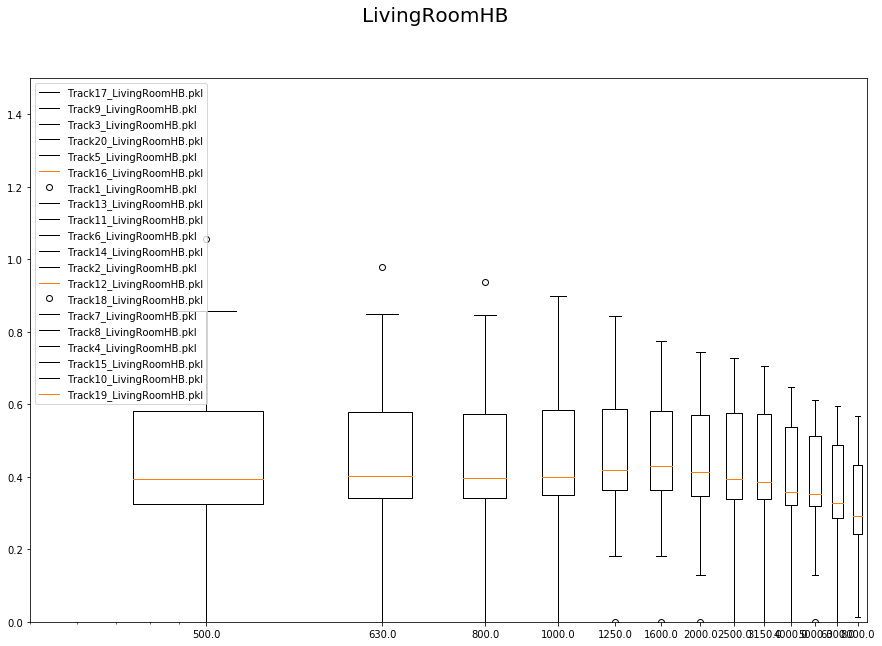

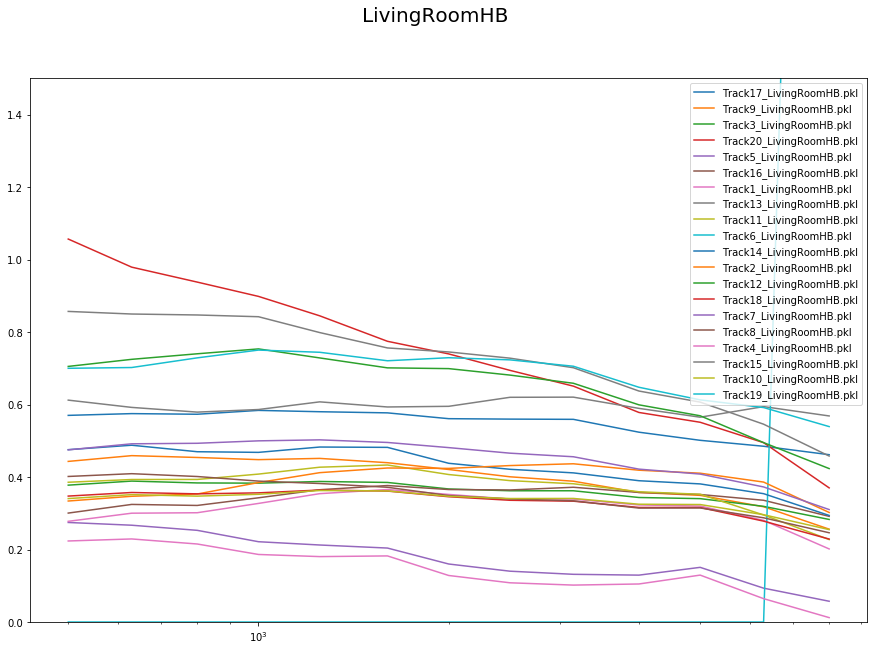

roomfolder : Datasets/Logi_measures/Preprocessed/X/LogiDOUG


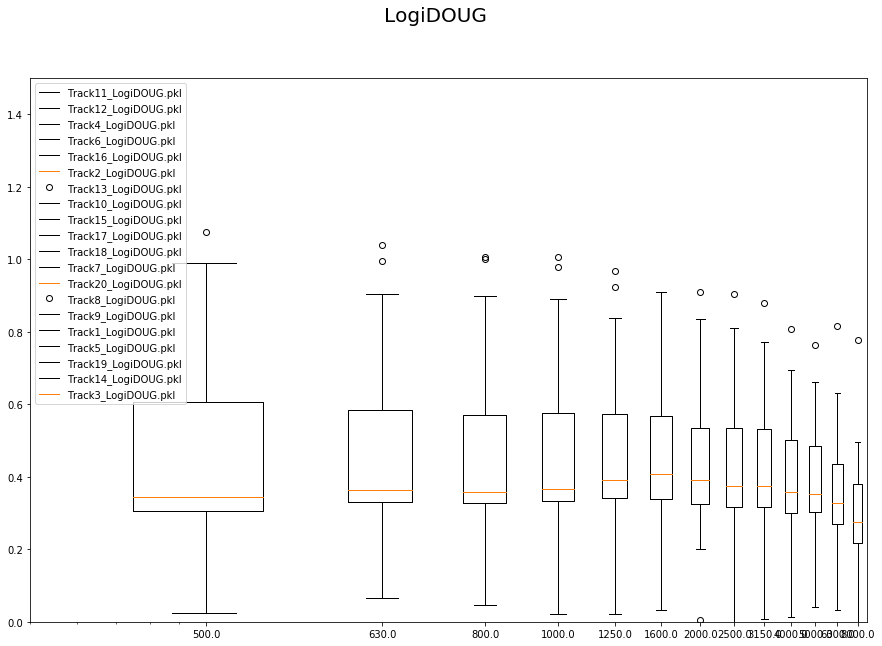

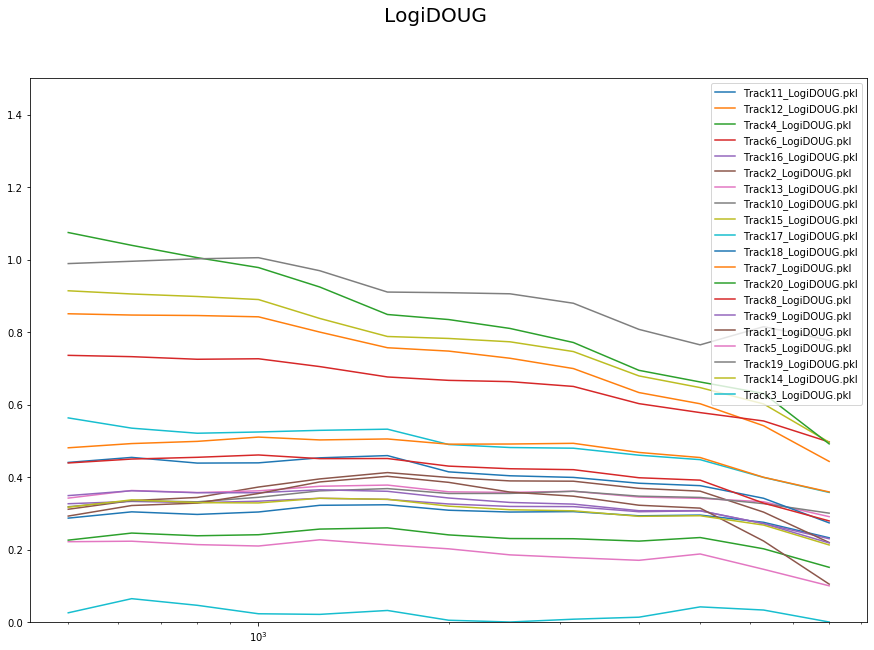

roomfolder : Datasets/Logi_measures/Preprocessed/X/LogiLounge


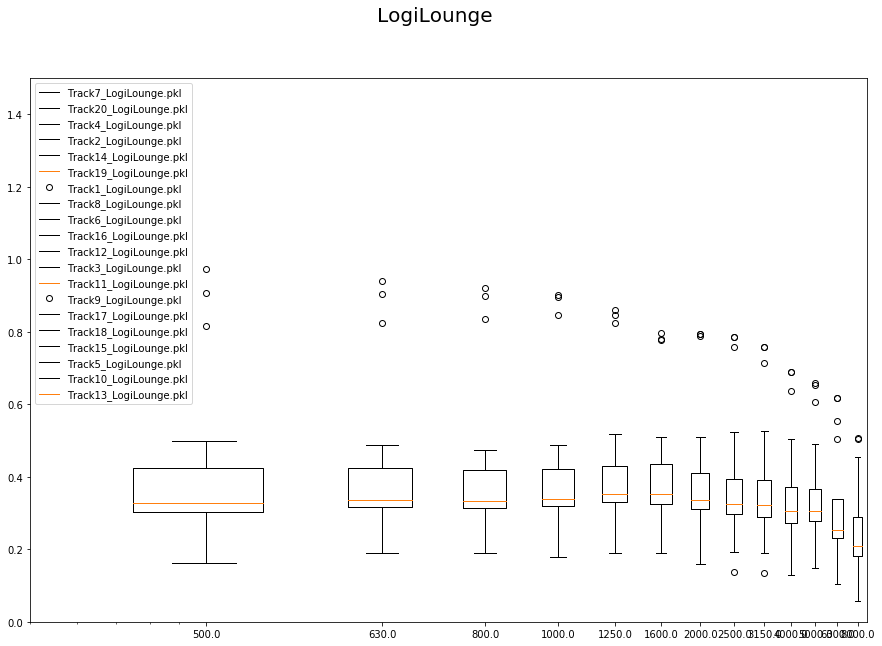

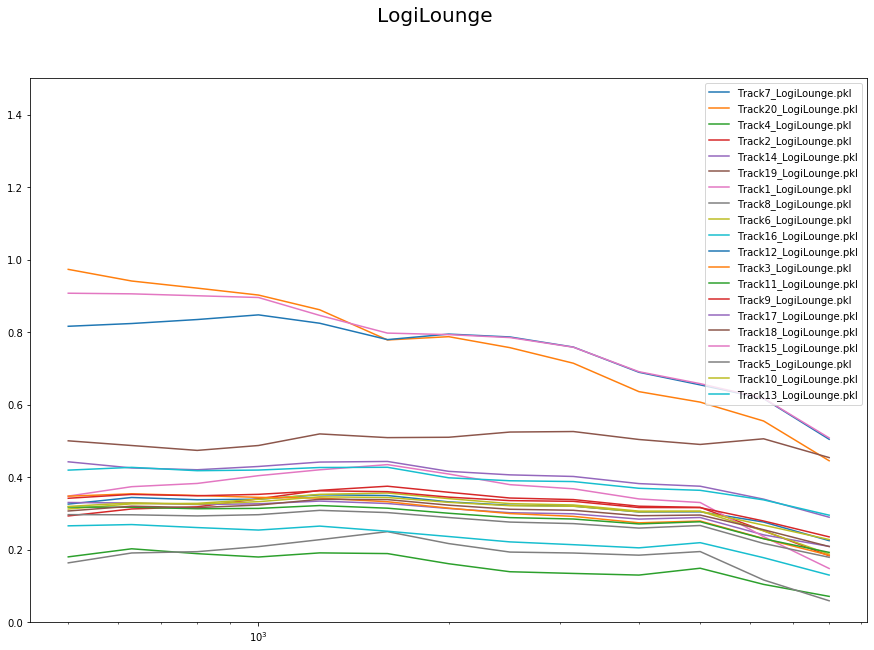

roomfolder : Datasets/Logi_measures/Preprocessed/X/LogiPod13


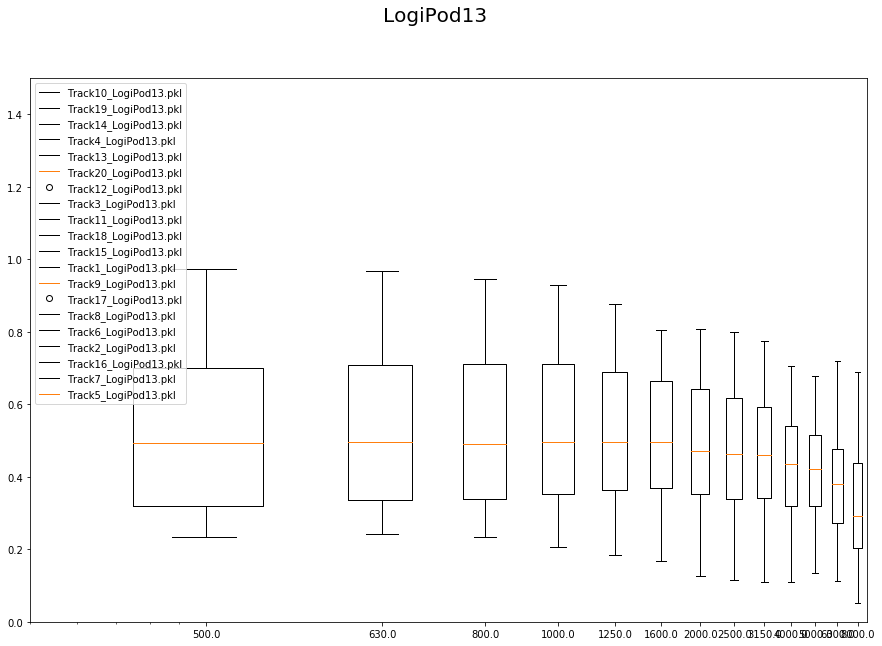

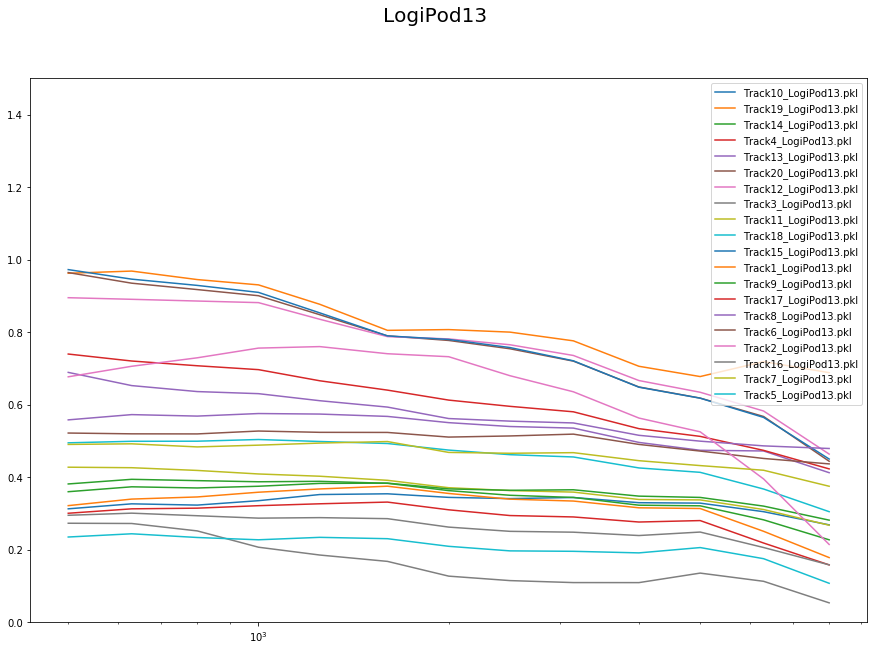

roomfolder : Datasets/Logi_measures/Preprocessed/X/LivingRoom


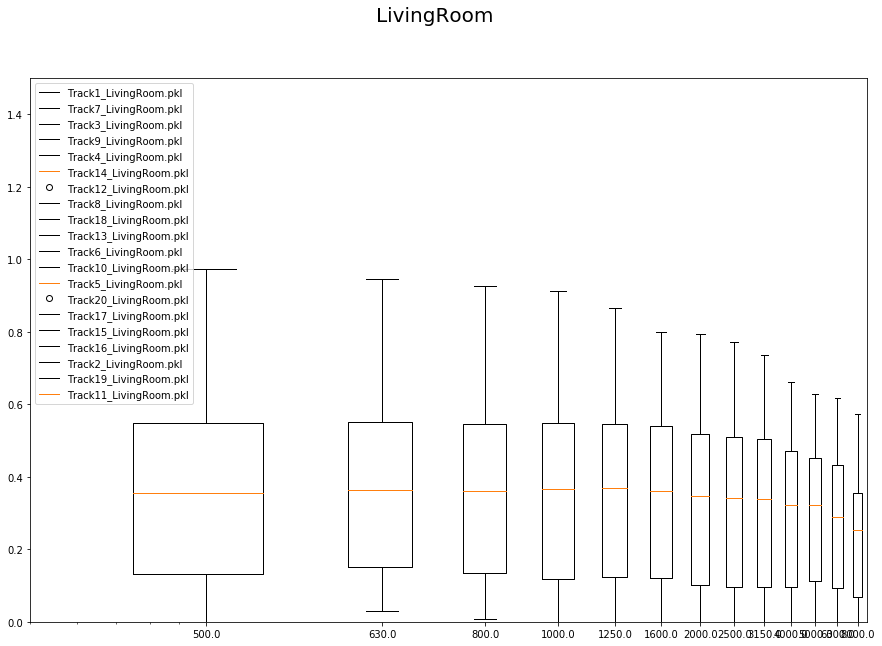

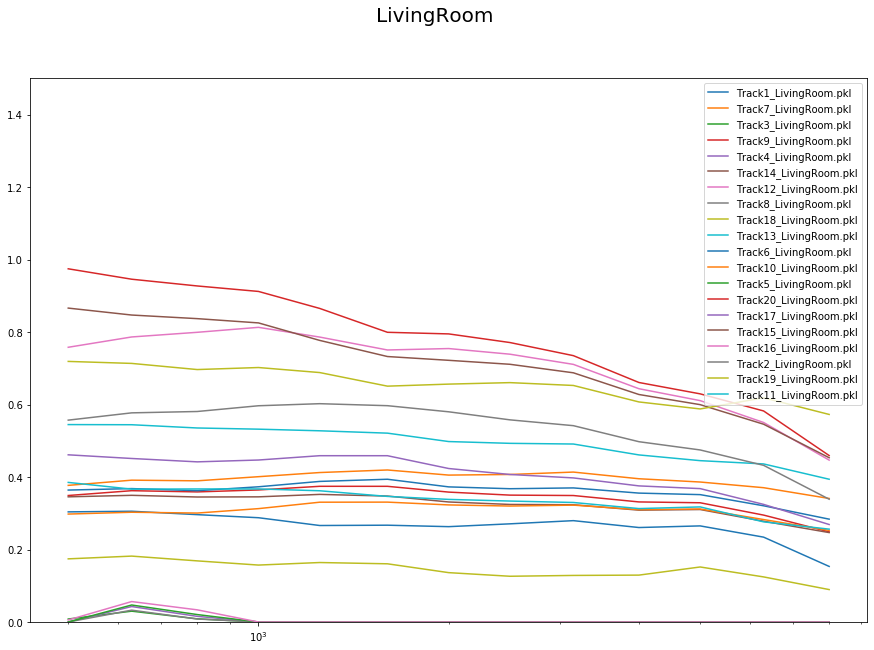

In [17]:
for room_folder_num in glob.glob(dataset_folder+'X/*'):
    room_name = os.path.split(room_folder_num)[1]
    track_names = [os.path.split(track)[1] for track in glob.glob(room_folder_num + '/*.pkl')]
    print(f'roomfolder : {room_folder_num}')
    
    #print(room_name)
    #rir,fs = librosa.load(rir_folder + room_name + '_RIR.wav')
    #true_t60 = t60_impulse(rir,fs,bands)
    #print(f'{room_name} : {true_t60}')
    
    
    #plot_mean_prediction_vs_true_errbar(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)


    #plot_room_prediction([true_t60], room_name=room_name, track_names = ['True RT60'],show=False)
    #print(np.mean(room_prediction(room_folder_num,params),axis=0).shape)
    #plot_room_prediction([np.mean(room_prediction(room_folder_num,params),axis=0)],room_name=room_name,track_names='Mean predicted RT60')
    #boxplot_room_prediction_test(room_prediction(room_folder_num,params),true_t60,room_name=room_name,track_names=track_names)
    
    


    #plot_mean_prediction_vs_true(room_prediction(room_folder_num,params),[true_t60],room_name=room_name)
    boxplot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    plot_room_prediction(room_prediction(room_folder_num,params),room_name=room_name,track_names=track_names)
    

NameError: name 'y_true' is not defined

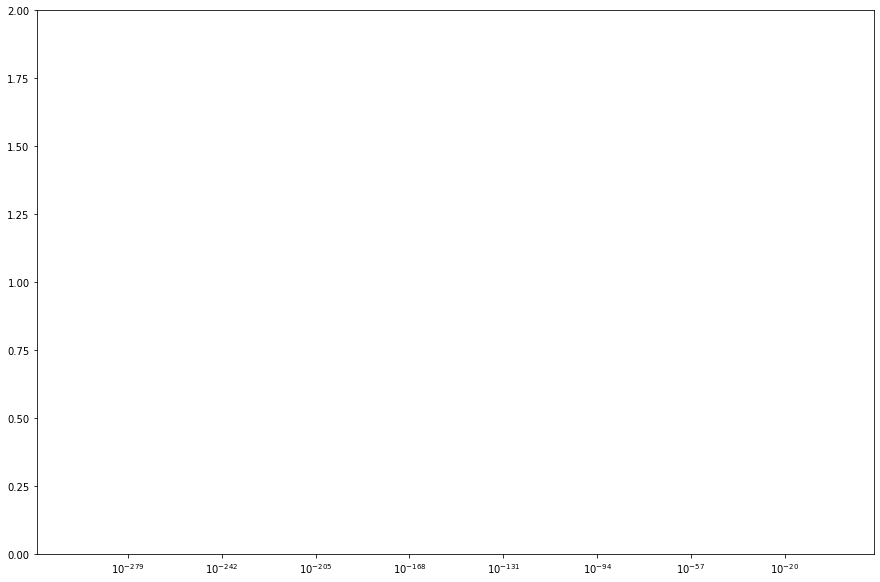

In [18]:


plt.figure(figsize=(15,10))
plt.xscale('log')
plt.ylim(bottom=0,top=2)
#t60 = acoustics.room.t60_impulse("RIRChambre.wav", bands)
plt.plot(bands, y_true.flatten())
plt.plot(bands, y_pred.flatten())
plt.legend(('y true', 'y pred'))
plt.show()

plt.figure(figsize=(15,10))
plt.xscale('log')
plt.ylim(bottom=0,top=2)
plt.plot(bands, y_true.flatten())
plt.plot(bands, y_pred_real.flatten())
plt.legend(('y true', 'y pred'))
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
real_error = mean_absolute_error(y_true, y_pred_real, sample_weight=None, multioutput='uniform_average')
conv_error = mean_absolute_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')
print(f'real error : {real_error}\nconv error : {conv_error}')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(y_true, y_pred_real, sample_weight=None, multioutput='uniform_average')

In [21]:
shiftval = 18

real_err_tab = []
conv_err_tab = []
shift=[]

for shiftval in range(40):
    print(f'shiftval = {shiftval}')

    dataset_folder = ("real_world_mfcc_data/")


    output_size = 13
    np.random.seed(44)
    test_indexes = np.random.randint(0, 1, size=1)

    y_true = np.empty((len(test_indexes),output_size))
    y_pred = np.empty((len(test_indexes),output_size))
    y_pred_real = np.empty((len(test_indexes),output_size))


    for i, index in enumerate(test_indexes):
        with open(dataset_folder + 'y/' + str(index) + '.pkl',"rb") as f:
            y_true[i] = pickle.load(f)
        f.close()
        with open(dataset_folder + 'X/' + str(index) + '.pkl',"rb") as f:
            X = pickle.load(f)
        f.close()
        y_pred[i] = model.predict(X.reshape((1,params['mfcc_bands'], params['window_size'],params['n_channels'])))

        with open(dataset_folder + 'X_real/' + str(index) + '.pkl',"rb") as f:
            X_real = pickle.load(f)
        f.close()
        y_pred_real[i] = model.predict(X_shifted.reshape((1,params['mfcc_bands'], params['window_size'],params['n_channels'])))

    rev_shifted = np.hstack((X_real[:,shiftval:,1],X_real[:,:shiftval,1]))
    music_X = X[:,:,0]
    print(rev_shifted.shape)
    X_shifted = np.dstack((music_X, rev_shifted))

    real_error = mean_absolute_error(y_true, y_pred_real, sample_weight=None, multioutput='uniform_average')
    conv_error = mean_absolute_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')
    shift.append(shiftval)
    real_err_tab.append(real_error)
    conv_err_tab.append(conv_error)
    print(f'real error : {real_error}\nconv error : {conv_error}')


shiftval = 0


NameError: name 'X_shifted' is not defined

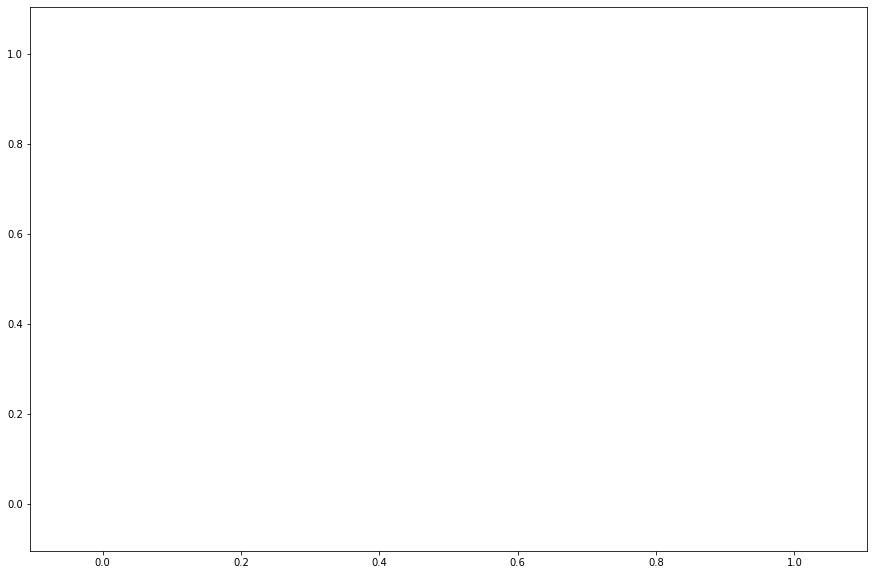

In [22]:
plt.figure(figsize=(15,10))
plt.plot(shift,real_err_tab)
plt.plot(shift,conv_err_tab)

